# Node representation learning through Unsupervised GraphSAGE  
### *with node classification on Cora citation dataset*

Stellargraph Unsupervised GraphSAGE is the implementation of GraphSAGE method outlined in the paper: ***[Inductive Representation Learning on Large Graphs.](http://snap.stanford.edu/graphsage/)*** W.L. Hamilton, R. Ying, and J. Leskovec arXiv:1706.02216
[cs.SI], 2017. 

This notebook is a short demo of how Stellargraph Unsupervised GraphSAGE can be used to learn embeddings of the nodes of the [CORA citation network](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz). Furthermore, this notebook demonstrates the use of the learnt embeddings in a downstream node classification task. Note that the node embeddings can also be used in other tasks, such as link prediction, community detection, etc.

### Unsupervised GraphSAGE:

A high-level explanation of the unsupervised GraphSAGE method of graph representation learning is as follows.

Objective: *Given a graph, learn embeddings of the nodes using only the graph structure and the node features, without using any known node class labels* (hence "unsupervised"; for semi-supervised learning of node embeddings, see this [demo](https://github.com/stellargraph/stellargraph/tree/master/demos/node-classification-graphsage/graphsage-cora-node-classification-example.ipynb))

**Unsupervised GraphSAGE model:** In the Unsupervised GraphSAGE model, node embeddings are learnt by solving a simple classification task: given a large set of "positive" `(target, context)` node pairs generated from random walks performed on the graph (i.e., node pairs that co-occur within a certain context window in random walks), and an equally large set of "negative" node pairs that are randomly selected from the graph according to a certain distribution, learn a binary classifier that predicts whether arbitrary node pairs are likely to co-occur in a random walk performed on the graph. Through learning this simple binary node-pair-classification task, the model automatically learns an inductive mapping from attributes of nodes and their neighbors to node embeddings in a high-dimensional vector space, which preserves structural and feature similarities of the nodes. Unlike embeddings obtained by algorithms such as [`node2vec`](https://snap.stanford.edu/node2vec), this mapping is inductive: given a new node (with attributes) and its links to other nodes in the graph (which was unseen during model training), we can evaluate its embeddings without having to re-train the model. 

In our implementation of Unsupervised GraphSAGE, the training set of node pairs is composed of an equal number of positive and negative `(target, context)` pairs from the graph. The positive `(target, context)` pairs are the node pairs co-occuring on random walks over the graph whereas the negative node pairs are sampled randomly from a global node degree distribution of the graph.

The architecture of the node pair classifier is the following. Input node pairs (with node features) are fed, together with the graph structure, into a pair of identical GraphSAGE encoders, producing a pair of node embeddings. These embeddings are then fed into a node pair classification layer, which applies a binary operator to those node embeddings (e.g., concatenating them), and passes the resulting node pair embeddings through a linear transform followed by a binary activation (e.g., sigmoid), thus predicting a binary label for the node pair. 

The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted node pair labels and true link labels) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' links generated on demand and fed into the model.

Node embeddings obtained from the encoder part of the trained classifier can be used in various downstream tasks. In this demo, we show how these can be used for predicting node labels.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

import keras 
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score


from stellargraph import globalvar

Using TensorFlow backend.
/anaconda3/envs/stgraph/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


### Loading the CORA network data

The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [2]:
data_dir = "~/data/cora"

Load the graph from edgelist.

In [3]:
edgelist = pd.read_table(os.path.join(data_dir, "cora.cites"), header=None, names=["source", "target"])
edgelist["label"] = "cites"  # set the edge type

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

Specify the node types.

In [5]:
nx.set_node_attributes(Gnx, "paper", "label")

Load the features and subject for the nodes.

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)

The node features are all attributes except the paper subject (we will use this for plotting the embeddings later). Paper subject label are not used for unsupervised training.

In [7]:
node_features = node_data[feature_names]

### Unsupervised GraphSAGE  with on demand sampling
The Unsupervised GraphSAGE requires a training sample that can be either provided as a list of `(target, context)` node pairs or it can be provided with an `UnsupervisedSampler` instance that takes care of generating positive and negative samples of node pairs on demand. In this demo we discuss the latter technique. 

#### UnsupervisedSampler:
The `UnsupervisedSampler` class takes in a `Stellargraph` graph instance. The `generator` method in the `UnsupervisedSampler`  is responsible for generating equal number of positive and negative node pair samples from the graph  for training. The samples are generated by performing uniform random walks over the graph, using `UniformRandomWalk` object. Positive `(target, context)` node pairs are extracted from the walks, and for each 
positive pair a corresponding negative pair `(target, node)` is generated by randomly sampling `node` from the degree distribution of the graph. Once the `batch_size` number of samples is accumulated, the generator yields a list of positive and negative node pairs along with their respective 1/0 labels.  

In the current implementation, we use uniform random walks to explore the graph structure. The length and number of walks, as well as the root nodes for starting the walks can be user-specified. The default list for root nodes is all nodes of the graph, default `number_of_walks` is 1 (at least one walk per root node), and the default `length` of walks is 2 (need at least one node beyond the root node on the walk as a potential positive context).

**1. Create the Stellargraph with node features.**

In [8]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [9]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



**2. Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk, and random seed.**

In [10]:
nodes = list(G.nodes())
number_of_walks = 1
length = 5

**3. Create the UnsupervisedSampler instance with the relevant parameters passed to it.**

In [11]:
unsupervised_samples = UnsupervisedSampler(G, nodes=nodes, length=length, number_of_walks=number_of_walks)

The graph G together with the unsupervised sampler will be used to generate samples.

**5. Create a node pair generator:**

Next, create the node pair generator for sampling and streaming the training data to the model. The node pair generator essentially "maps" pairs of nodes `(target, context)` to the input of GraphSAGE: it either takes minibatches of node pairs, or an `UnsupervisedSampler` instance which generates the minibatches of node pairs on demand. The generator samples 2-hop subgraphs with `(target, context)` head nodes extracted from those pairs, and feeds them, together with the corresponding binary labels indicating which pair represent positive or negative sample, to the input layer of the node pair classifier with GraphSAGE node encoder, for SGD updates of the model parameters.

Specify:
1. The minibatch size (number of node pairs per minibatch).
2. The number of epochs for training the model.
3. The sizes of 1- and 2-hop neighbor samples for GraphSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE encoder. In this example, we are defining a 2-layer GraphSAGE encoder.

In [12]:
batch_size = 50
epochs = 4
num_samples = [10, 5]

In the following we show the working of node pair generator with the UnsupervisedSampler, which will generate samples on demand.

In [13]:
train_gen = GraphSAGELinkGenerator(G, batch_size, num_samples).flow(unsupervised_samples)

Running GraphSAGELinkGenerator with an estimated 542 batches generated on the fly per epoch.


Build the model: a 2-layer GraphSAGE encoder acting as node representation learner, with a link classification layer on concatenated `(node1, node2)` node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive dropout rate, 0 < dropout < 1).
Note that the length of `layer_sizes` list must be equal to the length of `num_samples`, as `len(num_samples)` defines the number of hops (layers) in the GraphSAGE encoder.

In [14]:
layer_sizes = [50, 50]
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(
        layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.0, normalize="l2"
    )

In [15]:
# Expose input and output sockets of graphsage, for source and destination nodes:
x_inp_src, x_out_src = graphsage.default_model(flatten_output=False)
x_inp_dst, x_out_dst = graphsage.default_model(flatten_output=False)
# re-pack into a list where (source, destination) inputs alternate, for link inputs:
x_inp = [x for ab in zip(x_inp_src, x_inp_dst) for x in ab]
# same for outputs:
x_out = [x_out_src, x_out_dst]

Final node pair classification layer that takes a pair of nodes' embeddings produced by `graphsage` encoder, applies a binary operator to them to produce the corresponding node pair embedding ('ip' for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:

In [16]:
prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method='ip'
    )(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE encoder and prediction layer into a Keras model, and specify the loss

In [17]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

**6. Train the model.**

In [18]:
history = model.fit_generator(
        train_gen,
        epochs=epochs,
        verbose=1,
        use_multiprocessing=False,
        workers=0,
        shuffle=True,
    )

Epoch 1/4
542/542 [==============================] - 76s 139ms/step - loss: 0.5698 - binary_accuracy: 0.7448
Epoch 2/4
542/542 [==============================] - 76s 139ms/step - loss: 0.5449 - binary_accuracy: 0.7706
Epoch 3/4
542/542 [==============================] - 76s 139ms/step - loss: 0.5374 - binary_accuracy: 0.7877
Epoch 4/4
542/542 [==============================] - 75s 139ms/step - loss: 0.5373 - binary_accuracy: 0.7910


Note that multiprocessing is switched off, since with a large training set of node pairs, multiprocessing can considerably slow down the training process with the data being transferred between various threads. 

Also, multiple workers can be used with `Keras version 2.2.4` and it speeds up the training process considerably. However, we noticed that the multithreading behavior is unpredictable due to locking enabled on the generator when multiple threads are using the same instance of the `UnsupervisedSampler` for "on demand" sampling. We are working on the fix.

### Extracting node embeddings
Evaluate node embeddings as activations of the output of graphsage layer stack, and visualise them, coloring nodes by their subject label.

In [19]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

We use another Keras model to extract the embeddings for all the nodes.

**Building a new node-based model**

The GraphSAGE embeddings are the output of the GraphSAGE layers, namely the `x_out_src` variable. Let's create a new model with the same inputs as we used previously `x_inp_src` but now the output is the embeddings rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [20]:
node_ids = node_data.index

In [36]:
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(node_ids)

In [39]:
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

We now feed all nodes into the embedding model and extract their embeddings.

In [40]:
emb = embedding_model.predict_generator(node_gen, workers=4, verbose=1)
node_embeddings = emb[:,0,:]

55/55 [==============================] - 1s 22ms/step


#### Visualize the node embeddings 
Next we visualize the node embeddings in 2D using t-SNE. Colors of the nodes depict their true classes (subject in the case of Cora dataset) of the nodes. 

In [24]:
node_subject = node_data["subject"].astype('category').cat.codes

X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
    emb_transformed['label'] = node_subject
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] =  node_subject

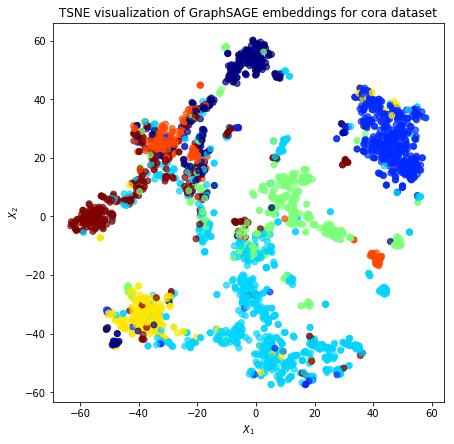

In [25]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GraphSAGE embeddings for cora dataset'.format(transform.__name__))
plt.show()

The observation that homogenously colored nodes in the embedding space are concentrated together is indicative  of similarity of embeddings of papers on the same topics. We would emphasize here again that the node embeddings are learnt without the true class labels. 

### Downstream task

The node embeddings calculated using the unsupervised GraphSAGE can be used as feature vectors in a downstream task such as node classification. 

In this example, we will use the  node embeddings to train a classifier to predict the subject of a paper in Cora.

In [26]:
# X will hold the 50 input features
X = node_embeddings  
# y holds the corresponding target values
y = np.array(node_subject)

### Data Splitting

We split the data into train and test sets. 

We use 20% of the data for training and the remaining 80% for testing as a hold out test set.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.20, test_size=None)

### Classifier Training

We train a Logistic Regression classifier on the training data. 

In [28]:
clf = LogisticRegression(verbose=3)
clf.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=3, warm_start=False)

Predict the hold out test set.

In [29]:
y_pred = clf.predict(X_test)

Calculate the accuracy of the classifier on the test set.

In [30]:
accuracy_score(y_test, y_pred)

0.7784956160590678

**Predicted classes**

In [31]:
pd.Series(y_pred).value_counts()

2    617
3    374
1    361
6    330
0    241
4    177
5     67
dtype: int64

**True classes**

In [32]:
pd.Series(y).value_counts()

2    818
3    426
1    418
6    351
0    298
4    217
5    180
dtype: int64

### Uses for unsupervised embeddings
1. Unsupervised GraphSAGE learns embedding of unlabeled graph nodes. This is highly useful as most of the real-world data is typically either unlabeled, or have noisy, unreliable, or sparse labels. In such scenarios unsupervised techniques that learn low-dimensional meaningful representation of nodes in a graph by leveraging the graph structure and features of the nodes is useful.
2. Moreover, GraphSAGE is an inductive technique that allows to obtain embeddings of unseen nodes, without the need to re-train the embedding model. That is, instead of training individual embeddings for each node, we learn a function that generates embeddings by sampling and aggregating features from nodes' local neighborhood.